# Finding Evidence of Weak Antilocalization in Twisted Bilayer Graphene

This analysis is a fun real-world example of using data and mathematical models to determine whether there is an effect called spin-orbit coupling in our graphene samples and at least order-of-magnitude estimates on some relevant parameters. Look in the readme document for a broader explanation on spin-orbit coupling and weak antilocalization. Here we will focus in a little more on the details.

Studies (like [this one](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.041020) and [this one](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.245402)) have shown that spin-orbit coupling can occur in single-layer and bilayer graphene when there is a material such as WSe$_2$ stacked next to the graphene. While there are some other indirect indicators, looking for weak antilocalization (a conductance that quickly dies at small magnetic fields, forming a distinct peak) is likely the most direct evidence for spin-orbit coupling that exists. We wanted to see if this effect would occur in twisted bilayer graphene close to the magic angle, which shows several anomalous behaviors like superconductivity and insulating states, which could possibly overrule the effect of spin-orbit coupling seen more readily in regular graphene samples.

We are looking for a peak at low magnetic fields that drops rapidly with magnetic field. As a reference, it's rare to see much change before hundreds of mT change in magnetic field, but this occurs on the order of 10 mT. The peak in conductance is the weak antilocalization. 

A couple things to note: 

- electrical transport measurements at low temperatures can be plagued by universal conductance fluctuations (UCF) that cause the conductance to fluctuate on the order of $e^2/h$, which is the same size as the peak, so we have to average a bunch of slightly different configurations to get the result.
- we are looking for parameters related to spin-orbit scattering times (also called relaxation times) that are due to spin-orbit coupling essentially knocking the electron spins around. The smaller the scattering times, the larger the spin-orbit coupling
- some parameters in the model are somewhat loosely experimentally determined, so we have to account for change in these parameters on some level

In [424]:
import numpy as np
import pandas as pd
import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, TwoSlopeNorm
from scipy.ndimage import gaussian_filter
from lmfit import Parameters, minimize, Minimizer, fit_report
import lmfit
from scipy.special import digamma
import multiprocessing
import logging
logger = logging.getLogger(__name__)

# import from our file model.py
import model

In [2]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 14

figfile = 'Figures/W5_WALpeaks/'

# Helper function
def val_to_index(valuefindarray, array):
    """Searches in array for the values in valuefindarray. Returns a list of
    indices.
    If the value isn't in the array, uses the closest value"""
    indarray = list([])
    count = 0
    for i in valuefindarray:
        if np.isin(i, array):
            indarray.append(list(array).index(i))
        else:
            closest = np.argmin(np.abs(array-i))
            indarray.append(closest)
            logger.debug('{:.2f} is not a value in the array. '.format(i) + 
                         'Plotted {:.2f} instead'.format(array[int(indarray[count])]))
        count += 1
    return indarray

# The same magnetic field array can be applied to most of these, so we define it up front
barr = np.linspace(-25, 25, 251)  # in mT

# We also determined the magnetic field to have an offset of -1 mT
b0 = -1.0

# A common quantity: the conductance quantum e^2/h, where e is electron charge, and h is Planck's constant
# (in units of mS, which we will use to measure conductance)
esqh = 1.602e-19**2/6.626e-34*1000

# There is an excitation current used
curr = 10e-9

# Load and pre-process the data

Data has already been pre-processed some and stored in arrays. Files indicate the device (W5), the excitation current used (necessary for calculation of resistance), the back gate voltage approximate midpoint (which controls the electron density in the graphene), the temperature, and the electrodes over which voltage is measured (##-##). The values in the arrays are the measured voltages.

You can get the gate values from the header of each .txt file.

The 2D arrays are stored with columns being the magnetic field (from -25 mT to 25 mT) and rows being the varying back gate voltage (the change in back gate voltage here is very small relative to the overall range).

The electrodes 39-38 (measured with the device called an SRS 830, hence the variable names) have been chosen since they provide decent looking data that symmetrizes well.

First, we will visualize the data at each temperature to make sure they are reasonable.

## Base Temperature (~25 mK)

In [3]:
# The gate array used at base temperature
garr2_base = np.linspace(-1.74, -2.34, 31)

# load the data
Vn2_830_base = np.loadtxt('./W5_WAL_arrays/W5_10nA_-2Vbg_baseT_39-38.txt')

# Note that pt 11 (-1.96V) in this array was messed up, so we remove it here
rmvind = [i != 11 for i in range(len(garr2_base))]
Vn2_830_base = Vn2_830_base[rmvind, :]
garr2_base = garr2_base[rmvind]

Text(0, 0.5, 'V$_{bg}$ (V)')

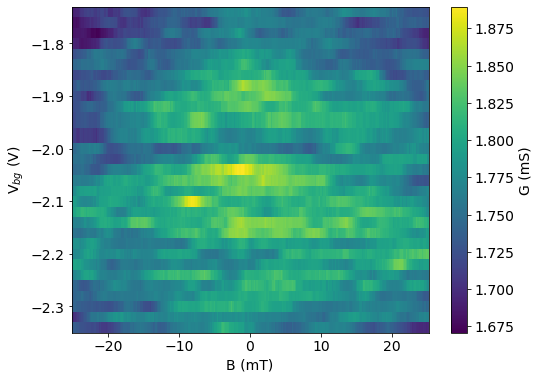

In [9]:
G_830_base = 1/(Vn2_830_base/10e-9) # The conductance

fig, ax1 = plt.subplots(1, 1)
p1 = ax1.pcolormesh(barr, garr2_base, G_830_base*1000, cmap='viridis')
plt.colorbar(p1, ax=ax1, label='G (mS)')
ax1.set_xlabel('B (mT)')
ax1.set_ylabel('V$_{bg}$ (V)')

Take a look at individual traces. They look all over the place at first, but they start to show a peak about 0 magnetic field. The actual trend can be seen better when averaging over small gate voltage differences, which we do later.

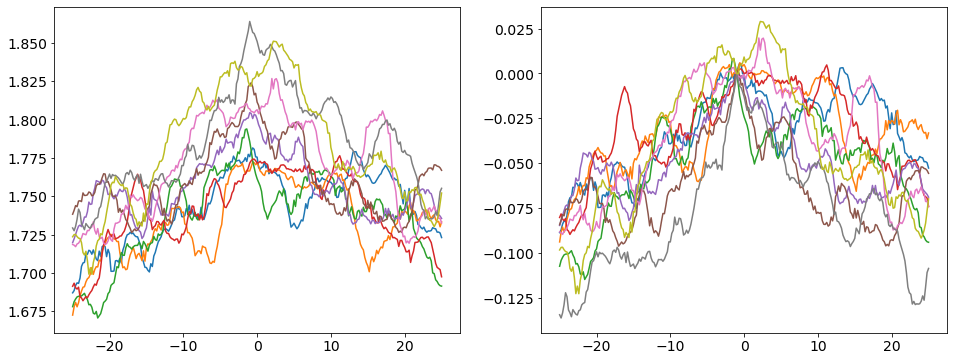

In [5]:
zindex = val_to_index([-1.0], barr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for i in range(G_830_base.shape[0]//4 + 2):
    ax1.plot(barr, G_830_base[i, :]*1000)
    ax2.plot(barr, (G_830_base[i, :] - G_830_base[i, zindex])*1000)


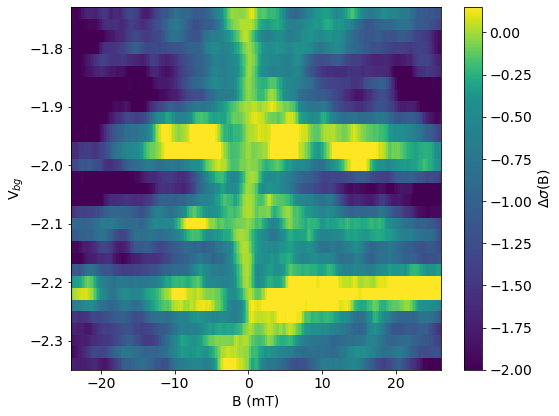

In [6]:
Gn2_830_base = 1/(Vn2_830_base/curr)*1000/esqh  # in units of e^2/h
dGn2_830_base = np.zeros(Vn2_830_base.shape)
pind = val_to_index([b0], barr)[0] # find the index of the 0-field pt
for i in range(Vn2_830_base.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_base[i, :] = Gn2_830_base[i, :] - Gn2_830_base[i, pind]

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr - b0, garr2_base, gaussian_filter(dGn2_830_base, (0.8,0.8)), cmap='viridis', norm=TwoSlopeNorm(vmin=-2, vmax=.15, vcenter=-0.4), rasterized=True) #vmin=-2, vmax=0.25,
plt.colorbar(label='$\Delta\sigma$(B)')
plt.ylabel('V$_{bg}$')
plt.xlabel('B (mT)')
plt.tight_layout()
# plt.savefig(figfile + 'W5_3938_WAL2dbase_-2Vbg.svg', bbox_inches='tight', dpi=300)

The consistent peak near B = 0 is what we want to see.

## 300 mK

In [10]:
Vn2_830_300 = np.loadtxt('./W5_WAL_arrays/W5_10nA_-2Vbg_300mK_39-38.txt')
garr2_300 = np.linspace(-1.74, -2.32, 30)

Text(0.5, 0, 'B (mT)')

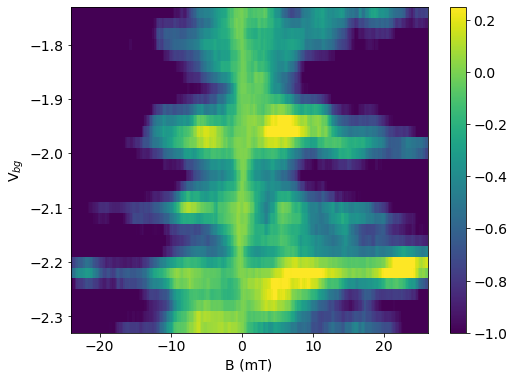

In [11]:
Gn2_830_300 = 1/(Vn2_830_300/curr)*1000/esqh  # in units of e^2/h
dGn2_830_300 = np.zeros(Vn2_830_300.shape)
pind = val_to_index([b0], barr)[0] # find the index of the 0-field pt
for i in range(Vn2_830_300.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_300[i, :] = Gn2_830_300[i, :] - Gn2_830_300[i, pind]

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr - b0, garr2_300, gaussian_filter(dGn2_830_300, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{bg}$')
plt.xlabel('B (mT)')

## 500 mK

In [12]:
Vn2_830_500 = np.loadtxt('./W5_WAL_arrays/W5_10nA_-2Vbg_500mK_39-38.txt')
garr2_500 = np.linspace(-1.74, -2.32, 30)  # same as 300 mK

Text(0.5, 0, 'B (mT)')

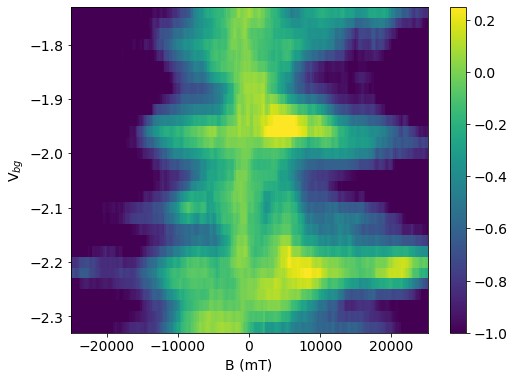

In [13]:
Gn2_830_500 = 1/(Vn2_830_500/curr)*1000/esqh  # in units of e^2/h
dGn2_830_500 = np.zeros(Vn2_830_500.shape)
pind = val_to_index([b0], barr)[0] # find the index of the 0-field pt
for i in range(Vn2_830_500.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_500[i, :] = Gn2_830_500[i, :] - Gn2_830_500[i, pind]

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr*1000 - b0, garr2_500, gaussian_filter(dGn2_830_500, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{bg}$')
plt.xlabel('B (mT)')

## 700 mK

In [14]:
Vn2_830_700 = np.loadtxt('./W5_WAL_arrays/W5_10nA_-2Vbg_700mK_39-38.txt')
garr2_700 = np.linspace(-1.74, -2.32, 30)  # same as the previous two

Text(0.5, 0, 'B (mT)')

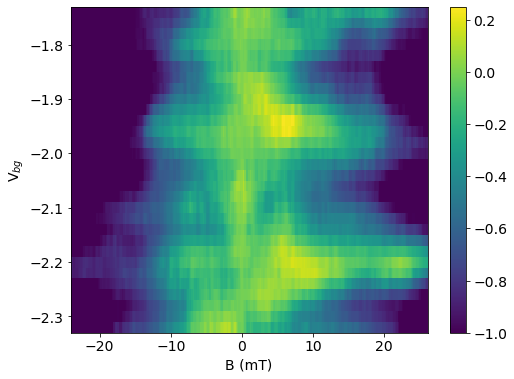

In [15]:
Gn2_830_700 = 1/(Vn2_830_700/curr)*1000/esqh  # in units of e^2/h
dGn2_830_700 = np.zeros(Vn2_830_700.shape)
pind = val_to_index([b0], barr)[0] # find the index of the 0-field pt
for i in range(Vn2_830_700.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_700[i, :] = Gn2_830_700[i, :] - Gn2_830_700[i, pind]

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr - b0, garr2_700, gaussian_filter(dGn2_830_700, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{bg}$')
plt.xlabel('B (mT)')

## 900 mK

In [16]:
Vn2_830_900 = np.loadtxt('./W5_WAL_arrays/W5_10nA_-2Vbg_900mK_39-38.txt')
garr2_900 = np.linspace(-1.74, -2.32, 30)  # same as the previous two

Text(0.5, 0, 'B (mT)')

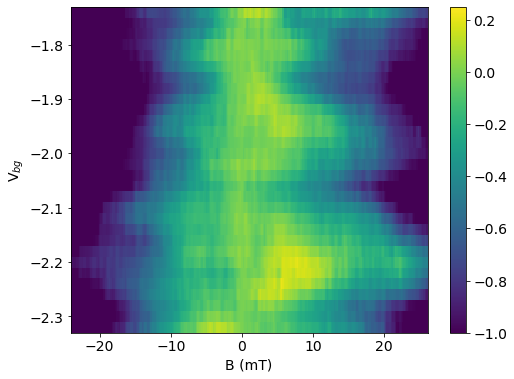

In [17]:
Gn2_830_900 = 1/(Vn2_830_900/curr)*1000/esqh  # in units of e^2/h
dGn2_830_900 = np.zeros(Vn2_830_900.shape)
pind = val_to_index([b0], barr)[0] # find the index of the 0-field pt
for i in range(Vn2_830_900.shape[0]):  # subtract the 0-field conductance from each 
    dGn2_830_900[i, :] = Gn2_830_900[i, :] - Gn2_830_900[i, pind]

plt.figure()  # lockin830 (39-38)
plt.pcolormesh(barr - b0, garr2_900, gaussian_filter(dGn2_830_900, (0.8,0.8)), vmin=-1, vmax=0.25, rasterized=True)
plt.colorbar()
plt.ylabel('V$_{bg}$')
plt.xlabel('B (mT)')

## Averaging down to curves at each temperature

A few things need to be done. The background needs to be removed, which is done by subtracting a curve at a temperature just above where the peak is visible. The best results were obtained (most flat at 700 mK and most symmetric) by subtracting the 900 mK data. 3K data was also taken, but the background subtraction didn't work was well with it.

Secondly, the model works best when the peaks are symmetrical, so we symmetrize.

In [18]:
def symmetrize(b, G, bpeak):
    """Enter the field values in b, conductance values in G, and the best estimate of the 
    field (in T) at the peak that should be at 0 field.
    
    This function assumes that bpeak is slightly less than 0 and, more importantly,
    that there are more field points above than below this point. It just concatenates points
    that can't be symmetrized.
    
    Returns a symmetrized b, G, G0 (or ignore G0 if you've already subtracted it)"""
    
    zptind = val_to_index([bpeak], b)[0]
    G0 = G[zptind]
    Gpsym = 0.5*(G[:zptind+1][::-1] + G[zptind:zptind + zptind + 1])
    Gsymm = np.concatenate((Gpsym[::-1], Gpsym[1:]))

    bpsymm = (b[zptind:2*zptind + 1] - b[zptind])
    bsymm = np.concatenate((-1*bpsymm[::-1], bpsymm[1:]))
    
    return bsymm, Gsymm, G0

Text(0, 0.5, '$\\Delta \\sigma (e^2/h)$')

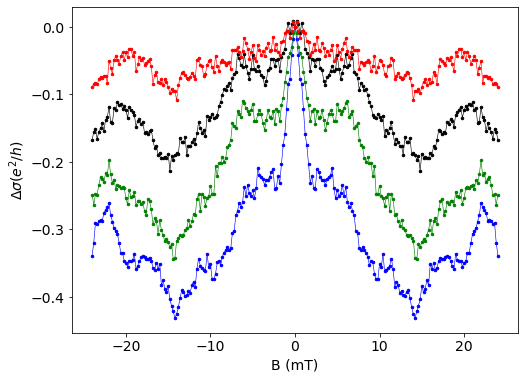

In [19]:
xmin, xmax = -25, 25
Msize = 5
LW = 0.6
plt.figure()
bsymm830base, Gsymm830base, G0 = symmetrize(barr, np.average(dGn2_830_base, axis=0) - np.average(dGn2_830_900, axis=0), -1)
plt.plot(np.ma.masked_outside(bsymm830base, xmin, xmax), Gsymm830base, '.-b', label='Base Temp', ms=Msize, lw=LW)
bsymm830300, Gsymm830300, G0 = symmetrize(barr, np.average(dGn2_830_300, axis=0) - np.average(dGn2_830_900, axis=0), -1)
plt.plot(np.ma.masked_outside(bsymm830300, xmin, xmax), Gsymm830300, '.-g', label='300 mK', ms=Msize, lw=LW)
bsymm830500, Gsymm830500, G0 = symmetrize(barr, np.average(dGn2_830_500, axis=0) - np.average(dGn2_830_900, axis=0), -1)
plt.plot(np.ma.masked_outside(bsymm830500, xmin, xmax), Gsymm830500, '.-k', label='500 mK', ms=Msize, lw=LW)
bsymm830700, Gsymm830700, G0 = symmetrize(barr, np.average(dGn2_830_700, axis=0) - np.average(dGn2_830_900, axis=0), -1)
plt.plot(np.ma.masked_outside(bsymm830700, xmin, xmax), Gsymm830700, '.-r', label='700 mK', ms=Msize, lw=LW)
plt.xlabel('B (mT)')
plt.ylabel('$\Delta \sigma (e^2/h)$')

We have a peak at low magnetic fields that grows as temperature decreases and that lessens almost to noise at about 700 mK. Now we can begin model fitting. We only need one side since it's symmetrical.

All the magnetic fields are also the same between tempeatures, so we will use a unified bsym

In [20]:
bsym = bsymm830base[121:]  # the function divides by 0 when 0 is included, so use the next point
Gsym_base = Gsymm830base[121:]
Gsym_300 = Gsymm830300[121:]
Gsym_500 = Gsymm830500[121:]
Gsym_700 = Gsymm830700[121:]

# Modeling the peak

The model is based on a bare graphene spin-orbit coupling model where the quantity on the y-axis, the conductance drop from 0 magnetic field ($\Delta \sigma$) is represented with the following equation, which comes from [this paper](https://link.aps.org/doi/10.1103/PhysRevLett.108.166606):

\begin{equation}
\Delta \sigma(B) = -\frac{e^2}{2\pi h} \left[ F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1}}\right) - F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1} + 2\tau_{asy}^{-1}}\right) - 2F\left(\frac{\tau_B^{-1}}{\tau_{\phi}^{-1} + \tau_{so}^{-1}}\right) \right].
\end{equation}



The relevant parameters we want to estimate from the are $\tau_{so}$ and $\tau_{asy}$, which are the scattering times for total spin-orbit coupling and for just the asymmetric portion of spin-orbit coupling. We can also use the symmetric spin-orbit coupling scattering time $\tau_{sym}$ since $\tau_{so}^{-1} = \tau_{sym}^{-1} + \tau_{asy}^{-1}$. These scattering times are on the order of picoseconds (ps) since this is the approximate scale of time it takes electrons to travel before losing coherence. When these times are smaller, it implies stronger spin-orbit coupling, which tends to knock electrons off course. Importantly, these scattering times do not change with temperature.

In front of the equation is a constant factor $-e^2/(2\pi h)$, and there are two more scattering parameters: 
- $\tau_{\phi}$ is an generally unknown parameter that varies with temperature but remains constant with magnetic field. While we do not know $\tau_{\phi}$ in all cases, we were able to empirically derive (through a procedure that isn't necessary to go through here) an estimate for base temperature: $\tau_{\phi} = 40.5$ ps, with some uncertainty involved in the estimate here. This significantly helps with constraining the parameter space.
- $\tau_B^{-1} = 4eDB/\hbar$. Here, $B$ is the magnetic field, $\hbar = h/(2\pi)$, and $D = 0.5v_F^2 \tau$ is a diffusion constant. 

To get the diffusion constant, we need the Fermi velocity, which we have determined through modeling to be $\sim1-4\times10^5$ m/s, reduced in TBG by a factor of 10 from the bare graphene Fermi velocity. However, this value varies depending on the exact modeling scheme used and introduces some play into the equations. We also need $\tau$, an scattering time that we get from the empirically derivable electron mobility, although it also relies on the Fermi velocity. Just for an approximate scale, when the Fermi velocity is $1\times10^5$, we have derived it to be $\tau \approx 1.549$ ps.

Finally, the $F(z)$ refers to the function

\begin{equation}
F(z) = \ln(z) + \psi(0.5 + 1/z),
\end{equation}

where $\psi(z)$ is the digamma function.

## Set up the model

In [21]:
hbar = 6.626e-34/(2*np.pi)

def F(z):
    return np.log(z) + digamma(0.5 + 1/z)

Start with defining $v_F = 10^5$ m/s to narrow down the number of tuned parameters.

We will use lmfit, a well-outfitted package that is based on scipy.optimize.curve_fit and includes some useful tools.

In [22]:
def dsigma_WAL(B, tau_phi, tau_asy, tau_sym, vF):
    """Defines the spin-orbit coupling fit equation. 
    Args: 
    B: magnetic field in mT, 
    tau_phi: T-dependent scattering time in ps
    tau_asy: asymmetric spin-orbit coupling scattering time in ps
    tau_sym: using the symmetric spin-orbit coupling instead of total so that the value
             isn't quite as constrained (it can be > or < tau_asy)
    
    Note they've been scaled appropriately below. Scaled params are appended with an 's'
    to avoid namespace issues.
    
    Returns: The theoretical change in conductivity from B=0, in units of e^2/h 
    (which has to be converted from mS)
    """
    
    tau = 15982e-4*hbar*np.sqrt(np.pi*0.69021e16)/(1.602e-19*vF)
    D = 0.5*vF**2*tau
    B_s = B/1000
    tau_phi_s = tau_phi*1e-12
    tau_asy_s = tau_asy*1e-12
    tau_sym_s = tau_sym*1e-12
    tau_so_s = (tau_asy_s**(-1) + tau_sym_s**(-1))**(-1)
    tau_binv = 4*D*1.602e-19*B_s/(6.626e-34/(2*np.pi))
    return -1.602e-19**2/(2*np.pi*6.626e-34)/esqh*1000*(F(tau_binv/(tau_phi_s**-1)) \
                                                        - F(tau_binv/(tau_phi_s**-1 + 2*tau_asy_s**-1)) \
                                                        - 2*F(tau_binv/(tau_phi_s**-1 + tau_so_s**-1)))

For a complex model like this, it can help to manually find some reasonable values as a starting point.

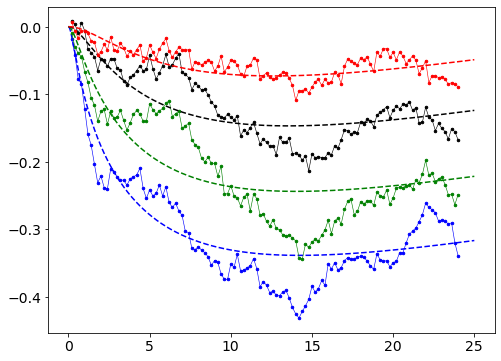

In [62]:
x = np.linspace(0.001, 25, 505)
t_asy, t_sym = 2, 3.5

plt.plot(x, dsigma_WAL(x, 40.5, t_asy, t_sym, 4.5e5), '--b')
plt.plot(bsym, Gsym_base, '.-b', label='Base Temp', ms=Msize, lw=LW)
plt.plot(x, dsigma_WAL(x, 21, t_asy, t_sym, 4.5e5), '--g')
plt.plot(bsym, Gsym_300, '.-g', label='Base Temp', ms=Msize, lw=LW)
plt.plot(x, dsigma_WAL(x, 10, t_asy, t_sym, 4.5e5), '--k')
plt.plot(bsym, Gsym_500, '.-k', label='Base Temp', ms=Msize, lw=LW)
plt.plot(x, dsigma_WAL(x, 5, t_asy, t_sym, 4.5e5), '--r')
plt.plot(bsym, Gsym_700, '.-r', label='Base Temp', ms=Msize, lw=LW)

We have a bit of a funny condition here, where we are fitting 4 separate curves, each with their own $\tau_{\phi}$ variables and with the same $\tau_{asy}$ and $\tau_{sym}$ variables. It helps to define it manually using a residuals function.

The fitting seems to be the most robust when $v_F = 4.5\times10^5$, so that's what we use.

In [501]:
params = Parameters()
params.add('vF', value=4.5e5, vary=False)  # start with keeping this constant. It's correlated with tau_phi1
params.add('tauphi_1', value=40.5, vary=False)
params.add('tauphi_2', value=21, min=0.01, max=41)  # tau_phi decreases with temperature
params.add('tauphi_3', value=10, min=0.01, max=41)
params.add('tauphi_4', value=5, min=0.01, max=41)
params.add('tau_asy', value=2, min=0.01, max=100)
params.add('tau_sym', value=3.5, min=0.01, max=100)

def residuals(params, B, data):
    p = params.valuesdict()
    vF = p['vF']
    tauphi_1, tauphi_2, tauphi_3, tauphi_4 = p['tauphi_1'], p['tauphi_2'], p['tauphi_3'], p['tauphi_4']
    tau_asy = p['tau_asy']
    tau_sym = p['tau_sym']
    
    nB = int(len(B)/4)  # divide the magnetic field into 4 sections, one for each model
    dsigma1 = dsigma_WAL(B[:nB], tauphi_1, tau_asy, tau_sym, vF)
    dsigma2 = dsigma_WAL(B[nB:2*nB], tauphi_2, tau_asy, tau_sym, vF)
    dsigma3 = dsigma_WAL(B[2*nB:3*nB], tauphi_3, tau_asy, tau_sym, vF)
    dsigma4 = dsigma_WAL(B[3*nB:], tauphi_4, tau_asy, tau_sym, vF)
    
    ## direct residuals: gives 
    dsigma = np.concatenate((dsigma1, dsigma2, dsigma3, dsigma4))
    return (dsigma - data)  # the function squares it for us, so we can leave it like this

## Applying the model to the data

We use minimizer with two algorithms in series:

First basinhopping (from scipy.optimize.basinhopping), which includes a stochastic movement step and a local minimization step to search the parameter space efficiently. 

The leastsq method is the Levenberg-Marquardt method that has some more heuristics such as uncertainty estimates, but it's not as robust at finding solutions in complex non-linear equations. We feed the results from basinhopping into the leastsq algorithm.

In [502]:
Btot = np.concatenate((bsym, bsym, bsym, bsym))
Gtot = np.concatenate((Gsym_base, Gsym_300, Gsym_500, Gsym_700))
# save to file for use later
np.savetxt('./Data_array.txt', np.vstack((Btot, Gtot)), fmt='%.7e', 
           header='Data used for residuals. First row: magnetic field. \
           Second row, conductance in units of e^2/h')

mini = Minimizer(residuals, params, fcn_args=(Btot, Gtot))
out1 = mini.minimize(method='basinhopping')
out2 = mini.minimize(method='leastsq', params=out1.params)
print(fit_report(out1), '\n\n')
print(fit_report(out2))

[[Fit Statistics]]
    # fitting method   = basinhopping
    # function evals   = 29277
    # data points      = 480
    # variables        = 5
    chi-square         = 0.50052712
    reduced chi-square = 0.00105374
    Akaike info crit   = -3285.62221
    Bayesian info crit = -3264.75327
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    vF:        450000 (fixed)
    tauphi_1:  40.5 (fixed)
    tauphi_2:  19.7760421 (init = 21)
    tauphi_3:  8.80557647 (init = 10)
    tauphi_4:  4.13508489 (init = 5)
    tau_asy:   3.22690426 (init = 2)
    tau_sym:   1.01917995 (init = 3.5) 


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 480
    # variables        = 5
    chi-square         = 0.500527

In [490]:
out2.params

name,value,standard error,relative error,initial value,min,max,vary
vF,450000.000,0.00000000,(0.00%),450000.0,-inf,inf,False
tauphi_1,40.5000000,0.00000000,(0.00%),40.5,-inf,inf,False
tauphi_2,19.7760416,0.58682398,(2.97%),19.77604306466722,0.01000000,41.0000000,True
tauphi_3,8.80557645,0.29379927,(3.34%),8.805576920091706,0.01000000,41.0000000,True
tauphi_4,4.13508474,0.18825857,(4.55%),4.135084917236734,0.01000000,41.0000000,True
tau_asy,3.22690062,0.83250752,(25.80%),3.22689857792785,0.01000000,100.000000,True
tau_sym,1.01918159,0.37085214,(36.39%),1.0191825738524312,0.01000000,100.000000,True


In [491]:
# We can get the useful values out if it from
out2.params['tau_asy'].value, out2.params['tau_asy'].stderr

(3.226900623890813, 0.8325075179075316)

We can calculate confidence intervals given an F-test and changing the parameters until they fall out of range.

In [492]:
ci = lmfit.conf_interval(mini, out2, sigmas=[0.2, 1, 2])
print(lmfit.printfuncs.ci_report(ci, with_offset=False))

             95.45%    68.27%    20.00%    _BEST_    20.00%    68.27%    95.45%
 tauphi_2:  18.60286  19.18466  19.62499  19.77604  19.92830  20.38251  21.00858
 tauphi_3:   8.23496   8.51665   8.73164   8.80558   8.88017   9.10295   9.41005
 tauphi_4:   3.76648   3.94955   4.08780   4.13508   4.18254   4.32397   4.51711
 tau_asy :   1.21528   1.25025   2.97516   3.22690   3.43994   3.96243   4.54899
 tau_sym :   0.61427   0.76185   0.93230   1.01918   1.14198       inf       inf


/Users/robertpolski/opt/anaconda3/envs/qcodes/lib/python3.8/site-packages/lmfit/confidence.py:334: UserWarning: rel_change=-0.011992663263679502 < 1e-05 at iteration 4 and prob(tau_sym=2.5025901571365727) = 0.48661872362498515 < max(sigmas).
  warn(errmsg)


Or a 2D confidence interval where two values are checked against each other.

In [503]:
cx, cy, grid = lmfit.conf_interval2d(mini, out2, 'tau_asy', 'tau_sym', 60, 60)
cx2, cy2, grid2 = lmfit.conf_interval2d(mini, out2, 'tau_sym', 'tauphi_2', 40, 40)
cx3, cy3, grid3 = lmfit.conf_interval2d(mini, out2, 'tau_asy', 'tauphi_2', 40, 40)
cx4, cy4, grid4 = lmfit.conf_interval2d(mini, out2, 'tauphi_2', 'tauphi_3', 30, 30)

Text(0.5, 0.98, '2D Confidence Interval (colors are percent confidence)')

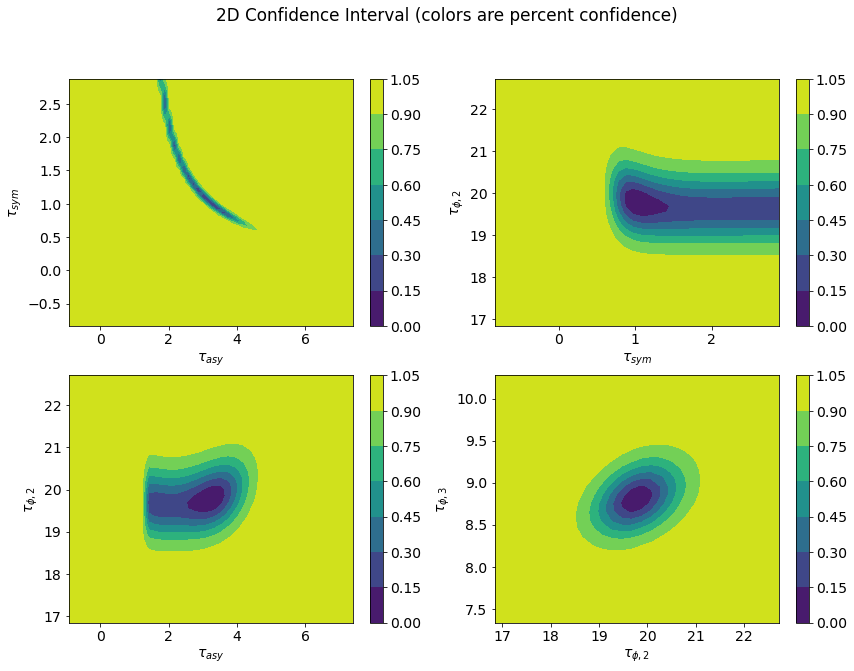

In [494]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
cont1 = ax[0, 0].contourf(cx, cy, grid)
fig.colorbar(cont1, ax=ax[0, 0])
ax[0, 0].set_xlabel('$\\tau_{asy}$')
ax[0, 0].set_ylabel('$\\tau_{sym}$')

cont2 = ax[0, 1].contourf(cx2, cy2, grid2)
fig.colorbar(cont2, ax=ax[0, 1])
ax[0, 1].set_xlabel('$\\tau_{sym}$')
ax[0, 1].set_ylabel('$\\tau_{\phi, 2}$')

cont3 = ax[1, 0].contourf(cx3, cy3, grid3)
fig.colorbar(cont3, ax=ax[1, 0])
ax[1, 0].set_xlabel('$\\tau_{asy}$')
ax[1, 0].set_ylabel('$\\tau_{\phi, 2}$')

cont4 = ax[1, 1].contourf(cx4, cy4, grid4)
fig.colorbar(cont4, ax=ax[1, 1])
ax[1, 1].set_xlabel('$\\tau_{\phi, 2}$')
ax[1, 1].set_ylabel('$\\tau_{\phi, 3}$')

fig.suptitle('2D Confidence Interval (colors are percent confidence)')
# plt.savefig('./Figures/2DCI_thintau.png', dpi=300, bbox_inches='tight')

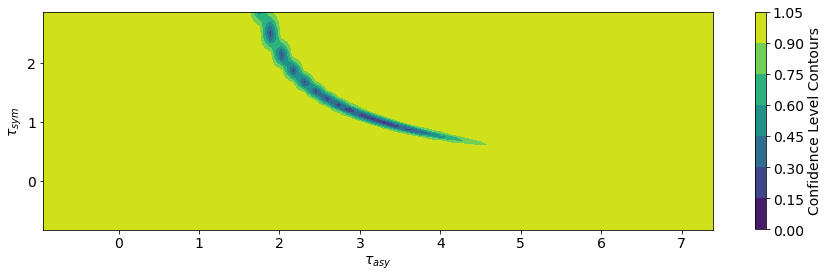

In [497]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), facecolor='white')
cont1 = ax.contourf(cx, cy, grid)
fig.colorbar(cont1, ax=ax, label='Confidence Level Contours')
ax.set_xlabel('$\\tau_{asy}$')
ax.set_ylabel('$\\tau_{sym}$')
# plt.savefig('./Figures/lopsided_CI.png', dpi=300)

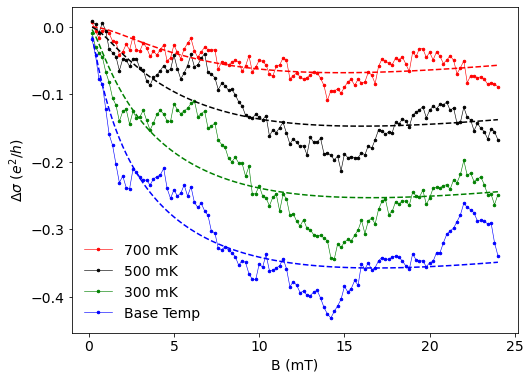

In [486]:
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.plot(bsym, Gsym_700, '.-r', label='700 mK', ms=Msize, lw=LW)
ax.plot(bsym, Gsym_500, '.-k', label='500 mK', ms=Msize, lw=LW)
ax.plot(bsym, Gsym_300, '.-g', label='300 mK', ms=Msize, lw=LW)
ax.plot(bsym, Gsym_base, '.-b', label='Base Temp', ms=Msize, lw=LW)

ax.plot(bsym, dsigma_WAL(bsym, out2.params['tauphi_4'].value, 
                         out2.params['tau_asy'].value, 
                         out2.params['tau_sym'].value,
                         out2.params['vF'].value), '--r')
ax.plot(bsym, dsigma_WAL(bsym, out2.params['tauphi_3'].value, 
                         out2.params['tau_asy'].value, 
                         out2.params['tau_sym'].value,
                         out2.params['vF'].value), '--k')
ax.plot(bsym, dsigma_WAL(bsym, out2.params['tauphi_2'].value, 
                         out2.params['tau_asy'].value, 
                         out2.params['tau_sym'].value,
                         out2.params['vF'].value), '--g')
ax.plot(bsym, dsigma_WAL(bsym, out2.params['tauphi_1'].value, 
                         out2.params['tau_asy'].value, 
                         out2.params['tau_sym'].value,
                         out2.params['vF'].value), '--b')

ax.legend(frameon=False)
ax.set_xlabel('B (mT)')
ax.set_ylabel('$\Delta\sigma$ ($e^2/h$)')

# plt.savefig('./Figures/Fit_lineplots.png', dpi=300)

These contour plots are the contours of the confidence interval, so ~0.68 (aqua-green) is the 1-sigma CI. $\tau_{sym}$ has a good lower confidence interval bound but is widespread at the upper bound, so it does not have a well defined confidence interval.

There are obvious correlations between the spin-orbit scattering times and in the spin-orbit scattering times mixed with T-dependent scattering times. Hoewver, the T-dependent scattering times together don't have obvious correlations, as seen above.

## Trying again with slightly different values of vF and tauphi_1

We can try the same with a lower value of vF, which seems to require a higher tauphi_1 to make the results turn out right. Perhaps the measurement of tauphi_1 was off.

In [498]:
params = Parameters()
params.add('vF', value=3.5e5, vary=False)  # start with keeping this constant. It's correlated with tau_phi1
params.add('tauphi_1', value=60, vary=False)
params.add('tauphi_2', value=21, min=0.01, max=50)  # tau_phi decreases with temperature
params.add('tauphi_3', value=10, min=0.01, max=50)
params.add('tauphi_4', value=5, min=0.01, max=50)
params.add('tau_asy', value=7, min=0.01, max=100)
params.add('tau_sym', value=1, min=0.01, max=100)

Btot = np.concatenate((bsym, bsym, bsym, bsym))
Gtot = np.concatenate((Gsym_base, Gsym_300, Gsym_500, Gsym_700))
mini = Minimizer(residuals, params, fcn_args=(Btot, Gtot))
out1 = mini.minimize(method='basinhopping', stepsize=0.2)
out2 = mini.minimize(method='leastsq', params=out1.params)
print(fit_report(out1), '\n\n')
print(fit_report(out2))

[[Fit Statistics]]
    # fitting method   = basinhopping
    # function evals   = 16254
    # data points      = 480
    # variables        = 5
    chi-square         = 0.52459938
    reduced chi-square = 0.00110442
    Akaike info crit   = -3263.07511
    Bayesian info crit = -3242.20618
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    vF:        350000 (fixed)
    tauphi_1:  60 (fixed)
    tauphi_2:  28.9737952 (init = 21)
    tauphi_3:  12.6907441 (init = 10)
    tauphi_4:  5.75650531 (init = 5)
    tau_asy:   7.78565788 (init = 7)
    tau_sym:   0.66909328 (init = 1) 


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 480
    # variables        = 5
    chi-square         = 0.52459938
 

Text(0, 0.5, '$\\tau_{\\phi, 3}$')

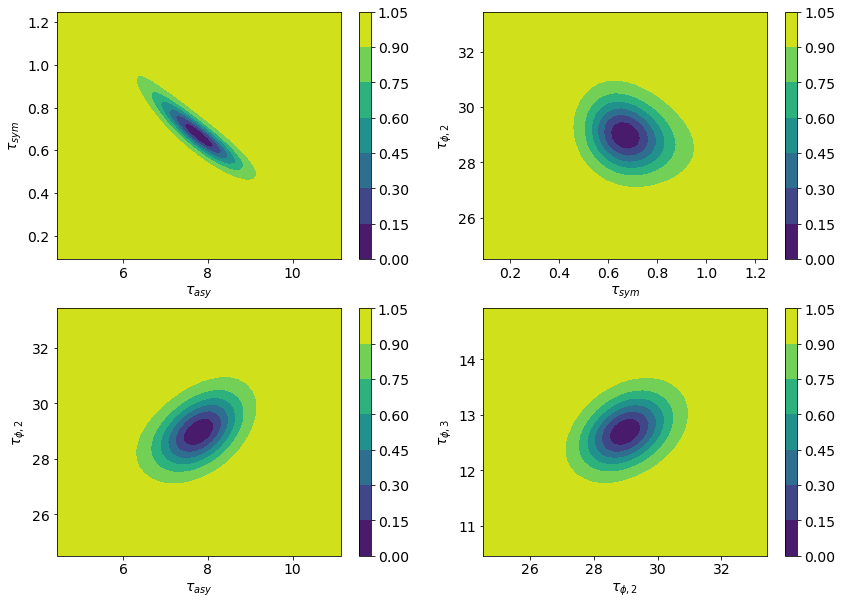

In [499]:
cx, cy, grid = lmfit.conf_interval2d(mini, out2, 'tau_asy', 'tau_sym', 60, 60)
cx2, cy2, grid2 = lmfit.conf_interval2d(mini, out2, 'tau_sym', 'tauphi_2', 40, 40)
cx3, cy3, grid3 = lmfit.conf_interval2d(mini, out2, 'tau_asy', 'tauphi_2', 40, 40)
cx4, cy4, grid4 = lmfit.conf_interval2d(mini, out2, 'tauphi_2', 'tauphi_3', 40, 40)

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
cont1 = ax[0, 0].contourf(cx, cy, grid)
fig.colorbar(cont1, ax=ax[0, 0])
ax[0, 0].set_xlabel('$\\tau_{asy}$')
ax[0, 0].set_ylabel('$\\tau_{sym}$')

cont2 = ax[0, 1].contourf(cx2, cy2, grid2)
fig.colorbar(cont2, ax=ax[0, 1])
ax[0, 1].set_xlabel('$\\tau_{sym}$')
ax[0, 1].set_ylabel('$\\tau_{\phi, 2}$')

cont3 = ax[1, 0].contourf(cx3, cy3, grid3)
fig.colorbar(cont3, ax=ax[1, 0])
ax[1, 0].set_xlabel('$\\tau_{asy}$')
ax[1, 0].set_ylabel('$\\tau_{\phi, 2}$')

cont4 = ax[1, 1].contourf(cx4, cy4, grid4)
fig.colorbar(cont4, ax=ax[1, 1])
ax[1, 1].set_xlabel('$\\tau_{\phi, 2}$')
ax[1, 1].set_ylabel('$\\tau_{\phi, 3}$')

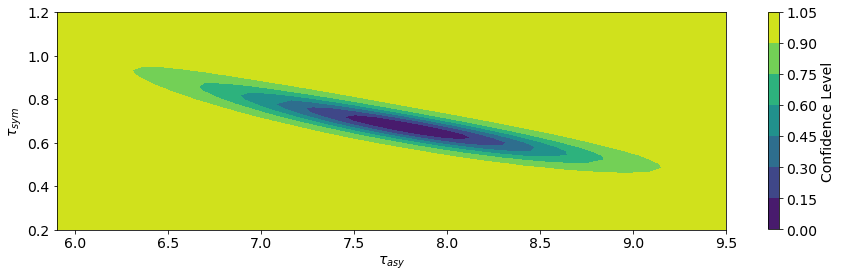

In [500]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4), facecolor='white')
cont1 = ax.contourf(cx, cy, grid)
fig.colorbar(cont1, ax=ax, label='Confidence Level')
ax.set_xlabel('$\\tau_{asy}$')
ax.set_ylabel('$\\tau_{sym}$')

ax.axis((5.9, 9.5, 0.2, 1.2))

# plt.savefig('./Figures/morenormalCI.png', dpi=300)

This is more stable but still shows highly correlated $\tau_{sym}$ and $\tau_{asy}$

## Another look into varying vF and tauphi_1

Lastly, try varying vF to see how the parameter estimates change

In [112]:
params = Parameters()
params.add('vF', value=3.5e5, min=2.5e5, max=4.5e5)
params.add('tauphi_1', value=60, vary=False)
params.add('tauphi_2', value=28, min=0.01, max=50)  # tau_phi decreases with temperature
params.add('tauphi_3', value=12, min=0.01, max=50)
params.add('tauphi_4', value=6, min=0.01, max=50)
params.add('tau_asy', value=7, min=0.01, max=100)
params.add('tau_sym', value=1, min=0.01, max=100)

Btot = np.concatenate((bsym, bsym, bsym, bsym))
Gtot = np.concatenate((Gsym_base, Gsym_300, Gsym_500, Gsym_700))
mini = Minimizer(residuals, params, fcn_args=(Btot, Gtot))
out1 = mini.minimize(method='basinhopping', T=0.05, stepsize=0.01)
out2 = mini.minimize(method='leastsq', params=out1.params)
print(fit_report(out1), '\n\n')
print(fit_report(out2))

[[Fit Statistics]]
    # fitting method   = basinhopping
    # function evals   = 12502
    # data points      = 480
    # variables        = 6
    chi-square         = 0.49049230
    reduced chi-square = 0.00103479
    Akaike info crit   = -3293.34326
    Bayesian info crit = -3268.30054
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    vF:        274518.618 (init = 350000)
    tauphi_1:  60 (fixed)
    tauphi_2:  30.2429866 (init = 28)
    tauphi_3:  13.4477390 (init = 12)
    tauphi_4:  6.30047061 (init = 6)
    tau_asy:   3.12800618 (init = 7)
    tau_sym:   3.12801519 (init = 1) 


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 480
    # variables        = 6
    chi-square         =

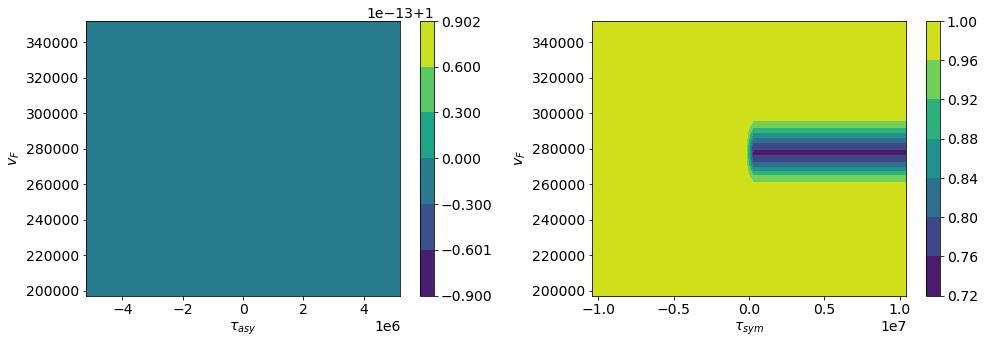

In [117]:
cx, cy, grid = lmfit.conf_interval2d(mini, out2, 'tau_asy', 'vF', 40, 40)
cx2, cy2, grid2 = lmfit.conf_interval2d(mini, out2, 'tau_sym', 'vF', 40, 40)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
cont1 = ax[0].contourf(cx, cy, grid)
fig.colorbar(cont1, ax=ax[0])
ax[0].set_xlabel('$\\tau_{asy}$')
ax[0].set_ylabel('$v_F$')

cont2 = ax[1].contourf(cx2, cy2, grid2)
fig.colorbar(cont2, ax=ax[1])
ax[1].set_xlabel('$\\tau_{sym}$')
ax[1].set_ylabel('$v_F$')
plt.tight_layout()

Varying vF did not work very well, even with tuning the basin hopping parameter. When we make vF or tauphi_1 varying, it tends to push the model into a regime where tau_asy and tau_sym have lots of uncertainty, as opposed to staying where the uncertainties behave properly. The Nelder-Mead algorithm does find a slightly better estimate, but it is likely a local minimum, and parameters passed from Nelder-Mead to Levenberg-Marquardt diverge again.

We can get a slightly better idea of what's happening by trying to visualize the effects of brute-forcing the parameters vF and tauphi_1 and minimizing each step.

We will use multiprocessing to break it up into asynchronous threads.

In [354]:
%%time
# Values to pass to the function
vF_vals = np.linspace(3e5, 4.5e5, 31)
tauphi1_vals = np.linspace(40, 90, 51)
vF_vals, tauphi1_vals = np.meshgrid(vF_vals, tauphi1_vals)
vF_vals_1d = vF_vals.reshape(-1)
tauphi1_vals_1d = tauphi1_vals.reshape(-1)

vF_tauphi_vals = list(zip(vF_vals_1d, tauphi1_vals_1d))

# split into 8 parts to speed it up
cpus = 8

def split_list(list_to_split, sections):
    L = len(list_to_split)
    section_size = L//sections
    if L%sections == 0:
        return list([list_to_split[section_size*i : section_size*i + section_size] \
                        for i in range(sections)])
    else:
        final_list = list([list_to_split[section_size*i : section_size*i + section_size] \
                            for i in range(sections-1)])
        final_section = list_to_split[int(section_size*(sections-1)):]
        final_list.append(final_section)
        return final_list

split_vF_tauphi_vals = split_list(vF_tauphi_vals, cpus)

vF_tauphi_vals_set = [set(subset) for subset in split_vF_tauphi_vals]

pool = multiprocessing.Pool(processes=cpus)

result_list = pool.map(model.run_Minimizer, vF_tauphi_vals_set)
pool.close()

CPU times: user 57.1 ms, sys: 75.8 ms, total: 133 ms
Wall time: 19min 21s


In [377]:
result_df = pd.concat(result_list, axis=0)

resultdf_multi = result_df.sort_values(['tauphi_1', 'vF'], axis=0).set_index(['tauphi_1', 'vF'])

In [369]:
resultdf_multi

tau_asy   tau_asy_std   tau_sym   tau_sym_std  chisquare
tauphi_1 vF                                                                  
40.0     300000.0   2.167810  2.641386e+06  2.167812  5.282778e+06   0.593112
         305000.0   2.166592  5.662838e+06  2.166592  1.132568e+07   0.582690
         310000.0   2.164995  1.077849e+06  2.164998  2.155702e+06   0.572981
         315000.0   2.163052  8.441939e+05  2.163056  1.688393e+06   0.563954
         320000.0   2.160791  1.229380e+06  2.160794  2.458766e+06   0.555578
...                      ...           ...       ...           ...        ...
90.0     430000.0  19.631656  7.547295e-01  0.010000  7.428371e-01   0.678117
         435000.0  19.692229  7.601357e-01  0.010000  8.390131e-01   0.681803
         440000.0  19.751847  7.394654e-01  0.010000  6.864581e-01   0.685485
         445000.0  19.810533  7.576041e-01  0.010000  7.113661e-01   0.689160
         450000.0  19.868314  6.728077e-01  0.010000  3.794385e-01   0.692830

[1581 rows x 5 columns]

In [380]:
result_df = resultdf_multi.reset_index()
result_df['vF'] = result_df['vF']/1e5

In [383]:
newshape = vF_vals.shape

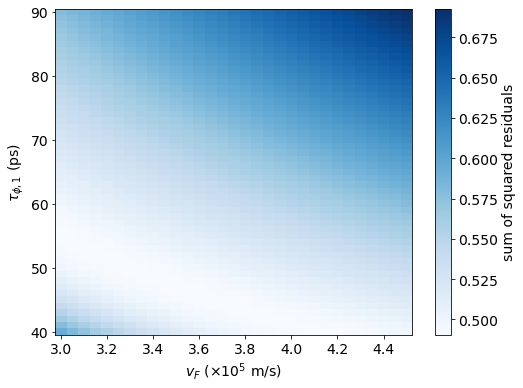

In [505]:
fig, ax = plt.subplots(1, 1, facecolor='white')
p1 = ax.pcolormesh(vF_vals/1e5, tauphi1_vals, result_df['chisquare'].values.reshape(newshape), cmap='Blues')
fig.colorbar(p1, ax=ax, label='sum of squared residuals')
ax.set_xlabel('$v_F$ ($\\times 10^5$ m/s)')
ax.set_ylabel('$\\tau_{\phi, 1}$ (ps)')

# plt.savefig('./Figures/Residuals_vf_tauphi1.png', dpi=300)

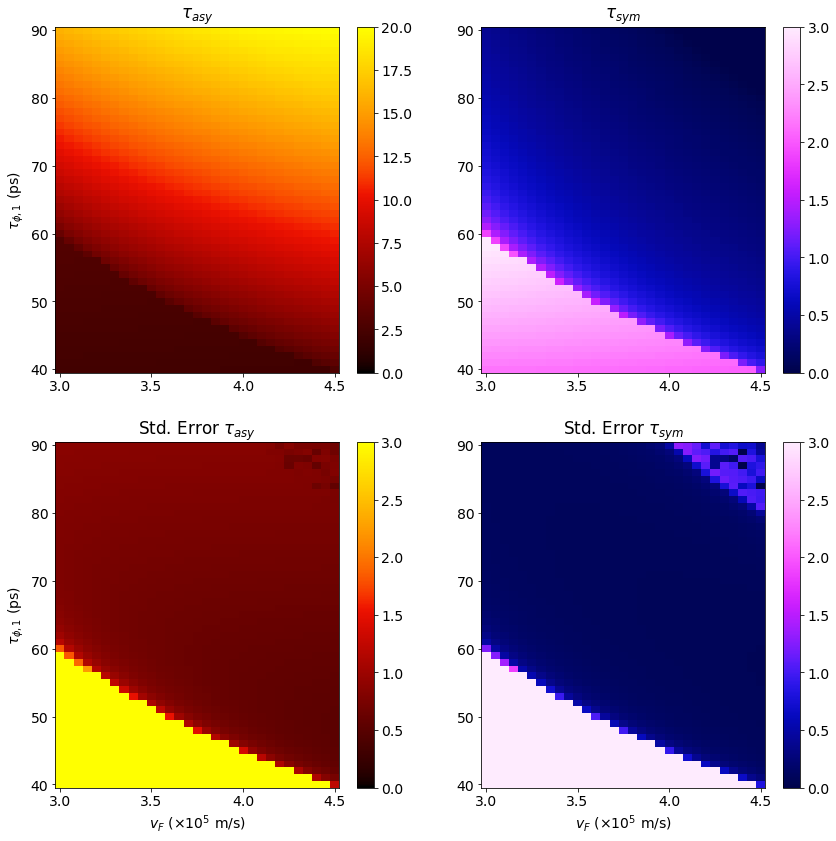

In [445]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14), facecolor='white')

ax1 = ax[0, 0]
p = ax1.pcolormesh(vF_vals/1e5, tauphi1_vals,
                   result_df['tau_asy'].values.reshape(newshape),
                   cmap=cc.cm.linear_kry_0_97_c73, vmin=0, vmax=20)
fig.colorbar(p, ax=ax1)
ax1.set_title('$\\tau_{asy}$')

ax2 = ax[0, 1]
p = ax2.pcolormesh(vF_vals/1e5, tauphi1_vals,
                   result_df['tau_sym'].values.reshape(newshape),
                   cmap=cc.cm.linear_bmw_5_95_c86, vmin=0, vmax=3)
fig.colorbar(p, ax=ax2)
ax2.set_title('$\\tau_{sym}$')

ax3 = ax[1, 0]
p = ax3.pcolormesh(vF_vals/1e5, tauphi1_vals,
                   result_df['tau_asy_std'].values.reshape(newshape),
                   cmap=cc.cm.linear_kry_0_97_c73, vmin=0, vmax=3)
fig.colorbar(p, ax=ax3)
ax3.set_title('Std. Error $\\tau_{asy}$')

ax4 = ax[1, 1]
p = ax4.pcolormesh(vF_vals/1e5, tauphi1_vals,
                   result_df['tau_sym_std'].values.reshape(newshape),
                   cmap=cc.cm.linear_bmw_5_95_c86, vmin=0, vmax=3)
fig.colorbar(p, ax=ax4)
ax4.set_title('Std. Error $\\tau_{sym}$')
    
ax[0, 0].set_ylabel('$\\tau_{\phi, 1}$ (ps)')
ax[1, 0].set_ylabel('$\\tau_{\phi, 1}$ (ps)')
ax[1, 0].set_xlabel('$v_F$ ($\\times 10^5$ m/s)')
ax[1, 1].set_xlabel('$v_F$ ($\\times 10^5$ m/s)')

# plt.savefig('./Figures/BruteForce_vf_tauphi1.png', dpi=300)

It seems there's a line above which vF and tauphi_1 allow for reasonable modeling. Given our derivations of these values, and the minimized residuals near the line, the true value likely lies close to this line, which is also where tau_asy is minimized and tau_sym is maximized. Below the value (in the left bottom of the diagrams), it appears the global minimum closes off, and the error blows up in the Levenberg-Marquadt minimizer.

## Conclusions

The exact values are hard to get, but all we need is order-of-magnitude estimations. 

It seems reasonable that, given a range of values of vF and tauphi_1 where the fitting behaves, we have $\tau_{asy}, \tau_{sym}$ both on the order of 1-10 ps. This puts the overall spin-orbit coupling in the same approximate range. 

Also, it appears favorable for $\tau_{asy} > \tau_{sym}$, with our results indicating somewhere in the range of $\tau_{asy}/\tau_{sym} \sim 2$-$10$, but this is also just an order-of-magnitude estimate. However, this value can get us an approximate importance of so-called Rashba spin-orbit coupling, which is symmetric, vs. the Ising spin-orbit coupling, which is asymmetric. The ratio between spin-orbit strengths depends on the square root, so we get a ratio on the order of 

\begin{equation}
    \sqrt{\frac{\tau_{asy}}{\tau_{sym}}} \approx 1-3.
\end{equation}